# Figure 2

- Notebook to make data for figure 2 (likely a map)
- by Cascade Tuholske on 2020.10.01

#### Depdencies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
import glob

#### Functions

In [99]:
def make_pdays(df_stats, df_pop):
    
    "Makes a dataframe with stats and population to calc people days"
    
    # Make Population Long Format
    pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
    pop_long.reset_index(level=0, inplace=True)
    pop_long.reset_index(level=0, inplace=True)
    pop_long = pop_long.drop('Unnamed: 0', axis = 1)
    
    # Get Total Days 
    data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
    pdays = pd.DataFrame()
    pdays['ID_HDC_G0'] = data['ID_HDC_G0']
    pdays['year'] = data['year']
    pdays['total_days'] = data['total_days']
    pdays['CTR_MN_NM'] = data['CTR_MN_NM']
    pdays['sub-region'] = data['sub-region']
    pdays['region'] = data['region']
    pdays['intermediate-region'] = data['intermediate-region']
    
    # Merge
    pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')

    # Now get people days from 1983 and change
    p = pd.DataFrame()
    p['ID_HDC_G0'] = df_pop['ID_HDC_G0']
    p['P1983'] = df_pop['P1983']
    p['P2016'] = df_pop['P2016']
#    p['p_delt'] = (df_pop['P2016'] - df_pop['P1983']) / df_pop['P1983'] * 100

    pdays_merge = pdays_merge.merge(p ,on=['ID_HDC_G0'], how = 'left')
    
    # Calc p days
    pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**6 # total people days
    pdays_merge['people_days_83'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**6 # people days w/ pop con
    pdays_merge['people_days_attr'] = pdays_merge['people_days'] - pdays_merge['people_days_83']  # dif
    
    return pdays_merge

In [90]:
def pop_stat(df, geog, stats):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography"""

    # Get results
    labels = []
    delt_list = []
    r2_list = []
    coef_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[stats].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        r2 = model.rsquared_adj
        p = model.pvalues[0]

        # Pop change
        delt = (df_geog['P2016'].sum() - df_geog['P1983'].sum())/df_geog['P1983'].sum() * 100

        # Make lists
        labels.append(label)
        r2_list.append(r2)
        coef_list.append(coef)
        p_list.append(p)
        delt_list.append(delt)

    # Make data frame
    df_out[geog] = labels
    df_out['p_delt'] = delt_list
    df_out['r2'] = r2_list
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]

    return df_out

# Load and Make Data

In [91]:
# file paths
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN_stats = 'heatrange/All_data20200109_406C_es_final.csv'
df_stats = pd.read_csv(DATA_IN+FN_stats)
# FIG_OUT = '/home/cascade/projects/figures/'

FN_pop = 'GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

In [100]:
df_data = make_pdays(df_stats, df_pop)

In [101]:
df_data.head()

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,region,intermediate-region,P,P1983,P2016,people_days,people_days_83,people_days_attr
0,2784,1983,1,Germany,Western Europe,Europe,Western Europe,9.976361e+05,997636.118717,1.573652e+06,0.997636,0.997636,0.000000
1,2784,2013,1,Germany,Western Europe,Europe,Western Europe,1.538112e+06,997636.118717,1.573652e+06,1.538112,0.997636,0.540476
2,2833,1983,1,Germany,Western Europe,Europe,Western Europe,6.014093e+04,60140.932532,6.497856e+04,0.060141,0.060141,0.000000
3,2833,1984,1,Germany,Western Europe,Europe,Western Europe,6.033127e+04,60140.932532,6.497856e+04,0.060331,0.060141,0.000190
4,2833,1998,1,Germany,Western Europe,Europe,Western Europe,6.411484e+04,60140.932532,6.497856e+04,0.064115,0.060141,0.003974


# Sub-Region Level Change

Here we want find the regions with the greatest increase in the total numbers of exposure days in a given year and then make graphs at the country level with a sig. trend line

In [142]:
stat = 'people_days_83'
geog = 'sub-region'
df_region = pop_stat(df_data, geog, stat)
df_region = df_region[df_region['p_value'] < 0.05]
sig_regions = list(df_region[geog])
len(sig_regions)

7

In [143]:
stat = 'people_days'

df_region_ = pop_stat(df_data, geog, stat)
df_region_ = df_region[df_region['p_value'] < 0.05]
sig_regions_ = list(df_region[geog])

df_region = df_region.merge(df_region_, on = geog, how = 'inner')

In [144]:
df_region

,sub-region,p_delt_x,r2_x,coef_x,p_value_x,p_delt_y,r2_y,coef_y,p_value_y
0,Eastern Asia,47.940489,0.217783,1.122733,0.0035,47.940489,0.217783,1.122733,0.0035
1,Latin America and the Caribbean,68.548835,0.165070,0.968131,0.0134,68.548835,0.165070,0.968131,0.0134
2,Northern Africa,100.808201,0.560317,16.416801,0.0000,100.808201,0.560317,16.416801,0.0000
3,Northern America,70.600328,0.307311,2.147691,0.0006,70.600328,0.307311,2.147691,0.0006
4,Southern Asia,76.254393,0.134325,78.364496,0.0266,76.254393,0.134325,78.364496,0.0266
5,Sub-Saharan Africa,142.361007,0.606347,16.959254,0.0000,142.361007,0.606347,16.959254,0.0000
6,Western Asia,140.520096,0.558585,22.843988,0.0000,140.520096,0.558585,22.843988,0.0000


Eastern Asia
Latin America and the Caribbean
Northern Africa
Northern America
Southern Asia
Sub-Saharan Africa
Western Asia


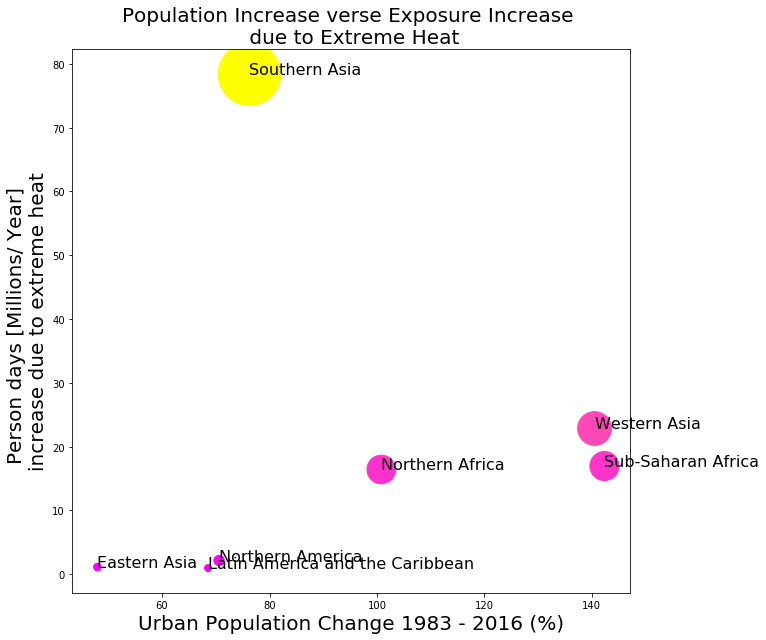

In [170]:
fig, axs = plt.subplots(1, figsize = (10, 10), sharex=True)
axs.scatter(df_region['p_delt_x'], df_region['coef_x'], s = df_region['coef_y']*50,
           c = df_region['coef_y']*50, cmap = 'spring') #df_region['coef'] /10**6)
# plt.yscale('log')
# plt.ylim(bottom = 0)

for i, row in df_region.iterrows():
    print(row['sub-region'])
    plt.annotate(row['sub-region'], (row['p_delt_x'], row['coef_x']),
                fontsize = 16) #row['coef']/10**6))

# Title
axs.set_title('Population Increase verse Exposure Increase \n due to Extreme Heat', fontsize = 20)
axs.set_ylabel('Person days [Millions/ Year] \nincrease due to extreme heat', fontsize = 20)
axs.set_xlabel('Urban Population Change 1983 - 2016 (%)', fontsize = 20)
axs.tick_params(labelsize = 10)

IndexError: index 4 is out of bounds for axis 0 with size 4

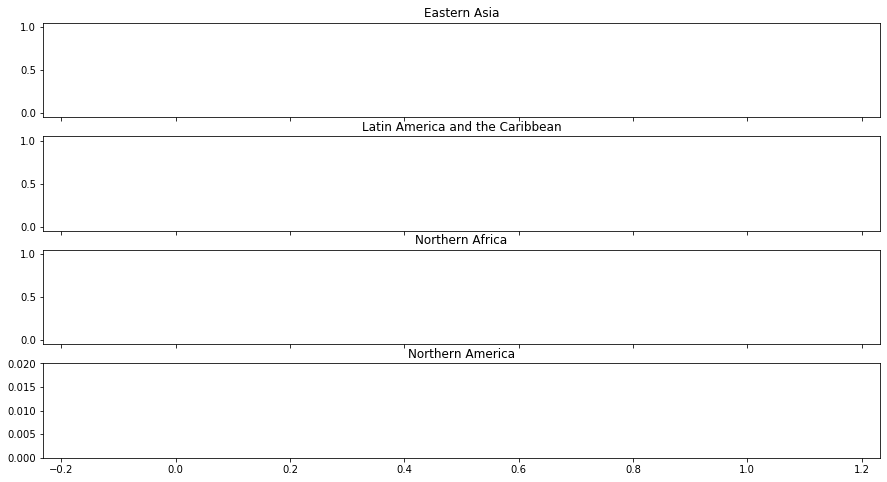

In [120]:
fig, axs = plt.subplots(4, figsize = (15, 8), sharex=True)
axs = axs.ravel()
plt.ylim(0, .02)

for i, region in enumerate(sig_regions):
    
    df_region = df_data[df_data['region'] == region] # select region
    countries = pop_stat(df_region, 'CTR_MN_NM', stat) # get stats
    countries = countries[countries['p_value'] < 0.05] # subset
    
    # plot it
    axs[i].scatter(countries['p_delt'], countries['coef'])
    axs[i].set_title(region)
    
    # Set lims
#     axs[i].set_ylim(bottom = 0)
#     #axs[i].set_xlim([0, 800])


    
    #print(countries['CTR_MN_NM'])
    
    for j, row in countries.iterrows():
        axs[i].annotate(row['CTR_MN_NM'], (row['p_delt'], row['coef']))


In [ ]:
stat = 'total_days'
df_region = pop_stat(df_data, 'CTR_MN_NM', stat)
df_region = df_region[df_region['p_value'] < 0.05]

In [ ]:
fig, axs = plt.subplots(1, figsize = (10, 10), sharex=True)
axs.scatter(df_region['p_delt'], df_region['coef'])
# plt.yscale('log')
plt.ylim(top=100)

for j, row in df_region.iterrows():
    axs.annotate(row['CTR_MN_NM'], (row['p_delt'], row['coef']))

# Old Code

In [ ]:
for label, df_geog in df.groupby('ID_HDC_G0'):

    # Get Data
    X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df_geog.groupby('year')['total_days'].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit()
    print(label, model.params)
    print(len(model.params))
    print('P Value is', model.pvalues[0])
#     coef = model.params[1] # first param in intercept coef, second is slope of line
#     r2 = model.rsquared_adj
#     p = model.pvalues[0]

In [ ]:
test = df_data[df_data['CTR_MN_NM'] == 'Nigeria']
test[test['year'] == 1983]['total_days'].sum()

In [ ]:
test = test[test['ID_HDC_G0'] == 3101]
test

In [ ]:
X_year = np.array(test.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(test.groupby('year')['total_days'].sum()).reshape((-1, 1))

In [ ]:
# Add Intercept
X_year_2 = sm.add_constant(X_year)

# Regress
model = sm.OLS(Y_stats, X_year_2).fit()

In [ ]:
plt.scatter(X_year, Y_stats)
plt.scatter(X_year, model.predict(X_year_2), color = 'red')

In [ ]:
model.summary()

In [ ]:
# test reg and plot
test = df_data[df_data['CTR_MN_NM'] == 'India']
stats = 'people_days'

# X & Y 
X_year = np.array(test.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(test.groupby('year')[stats].sum()).reshape((-1, 1))

In [ ]:
plt.scatter(X_year, Y_stats)

In [ ]:
X_year_2 = sm.add_constant(X_year)
model_int = sm.OLS(Y_stats, X_year_2).fit()
pred_int = model_int.predict(X_year_2)
plt.scatter(X_year, pred_int, color = 'red')
plt.title('W/ Intercept')

In [ ]:
model_int.summary()

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()
model.summary()

In [ ]:
plt.scatter(X_year, pred_int, color = 'red')
plt.scatter(X_year, Y_stats, color = 'blue')

In [ ]:
df = df_data[df_data['CTR_MN_NM'] == 'Nigeria']

In [ ]:
test = pop_stat(df_data, 'sub-region', 'total_days')

In [ ]:
df = test[test['p_value'] < 0.01]

In [ ]:
df_out

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

ax1.scatter(df_out['p_delt'], df_out['coef'])
#plt.xscale('log')
#plt.yscale('log')
# plt.xlim(100, 700)
# plt.ylim(0, 100)

for i, row in df_out.iterrows():
    plt.annotate(row['sub-region'], (row['p_delt'], row['coef']))


# Label Points
    #loop through data points and plot each point 
#     for l, row in data.loc[data['label']==label,:].iterrows():
    
#         #add the data point as text
#         plt.annotate(row['label'], 
#                      (row['x'], row['y']),
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      size=11,
#                      color=customPalette[i]) 


# # Title
# ax1.set_title('Change in Population vs Change in Extreme Heat', fontsize = 20)
# ax1.set_ylabel('Avg. Additional Days Per Year > 40.6C ', fontsize = 20)
# ax1.set_xlabel('Change in Population (%) 1983 - 2016', fontsize = 20)
# ax1.tick_params(labelsize = 15)

In [ ]:
ct = df_data[df_data['sub-region'] == 'Sub-Saharan Africa']
df_out = pop_stat(ct, 'ID_HDC_G0', 'total_days')
df_out = df_out[df_out['p_value'] < 0.01]
df_out

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

ax1.scatter(df_out['p_delt'], df_out['coef'])
plt.xscale('log')
plt.xlim(0,10000)

# for i, row in df_out.iterrows():
#     plt.annotate(row['ID_HDC_G0'], (row['p_delt'], row['coef']))
